# Employing Machine Learning in the Study of Differential Equations Related to Nuclear Engineering

## Neural Network Solution Approximation for ODE's

##### Marina Zafiris, Dr. Katarina Jegdic
##### University of Houston – Downtown


   Differential equations model a variety of phenomena in sciences and engineering. The main focus of this project is on time-dependent partial differential equations known as conservation laws that are used to model multiphase flows. In particular, these equations are of interest to engineers who design nuclear reactor pipes to ensure the optimal flow of gasses and liquids.
   
   Most of differential equations that describe the real-world phenomena cannot be solved exactly and one has to utilize an approximation method to obtain an approximate solution. Some of the most well-known and widely used numerical methods for solving conservation laws are finite difference, finite volume, and finite element methods. They have been studied extensively for the past 60 years and, together with analytical studies, have also provided insights regarding the structure of the exact solutions.
   
   In this project, the emphasis is on relatively recent methods for solving differential equations that utilize machine learning and, in particular, neural networks, motivated by the universal approximation theorem. In this approach, by Lagaris, Likas, and Fotiadis, a trial solution is proposed consisting of two parts – the first part, satisfying the initial/boundary conditions, with no adjustable parameters, and the second part consists of a neural network that is trained to satisfy the differential equation by minimizing the squared error loss. A common neural network parameters are learned by minimizing the mean squared error loss consisting of two terms – the first term corresponding to the initial/boundary conditions and the second term corresponding to the governing differential equation.

In [2]:
import autograd.numpy as np
from autograd import grad 
import autograd.numpy.random as npr

from autograd.core import primitive

from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
nx = 10
dx = 1. / nx

## Analytical

In [4]:

def A(x):
    '''
        Left part of initial equation
    '''
    return x + (1. + 3.*x**2) / (1. + x + x**3)


def B(x):
    '''
        Right part of initial equation
    '''
    return x**3 + 2.*x + x**2 * ((1. + 3.*x**2) / (1. + x + x**3))


def f(x, psy):
    '''
        d(psy)/dx = f(x, psy)
        This is f() function on the right
    '''
    return B(x) - psy * A(x)


def psy_analytic(x):
    '''
        Analytical solution of current problem
    '''
    return (np.exp((-x**2)/2.)) / (1. + x + x**3) + x**2

## Finite Difference

Implementing a well-known Lax-Friedrich finite difference numerical method [6]

In [5]:
x_space = np.linspace(0, 1, nx)    
y_space = psy_analytic(x_space)
psy_fd = np.zeros_like(y_space)
psy_fd[0] = 1. # IC

for i in range(1, len(x_space)):
    psy_fd[i] = psy_fd[i-1] + B(x_space[i]) * dx - psy_fd[i-1] * A(x_space[i]) * dx


## Neural Newtork

This approach [5] results in an approximating solution that is given in a differentiable, closed analytic form. The main idea is to consider a trial solution written as a sum of two parts. The first part is constructed to satisfy the initial/boundary conditions, while the second part is given in terms of a neural network whose parameters are learned by minimizing the squared error loss function that imposes the governing differential equation.

To show the simplicity of this definition, we consider an example of a second order ordinary differential equation, for an unknown function $\Psi(x)$ defined on the interval [0,1] with two-point Dirichlet boundary condition, in a general form where $F$ is a known function:

$\Psi''= F(x, \Psi, \Psi'), \Psi(1)=B$

The trial solution is defined by

$\Psi_{trial}(x) = A(1-x) + Bx + x(1-x)N(x,p)$

where, clearly, the first two terms ensure that the boundary conditions are satisfied. The last term, $N(x,p)$ represents a single output feed-forward neural network, with one hidden layer and sigmoid activation function, with input $x$ and adjustable parameters $p$ (weight and bias) that are used to minimize the squared error loss function. More precisely, the parameters p are learned through the minimization problem

$min_{p}\sum _{i}(\Psi''_{trial}(x_{i})- F(x_{i}, \Psi_{trial}(x_{i}), \Psi'_{trial}(x_{i})))^{2}$

where $xi$ are points from the interval [0,1]. The BFGS algorithm, see [4], is used for the minimization of the error.

In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid_grad(x):
    return sigmoid(x) * (1 - sigmoid(x))


def neural_network(W, x):
    a1 = sigmoid(np.dot(x, W[0]))
    return np.dot(a1, W[1])


def d_neural_network_dx(W, x, k=1):
    return np.dot(np.dot(W[1].T, W[0].T**k), sigmoid_grad(x))


def loss_function(W, x):
    loss_sum = 0.
    for xi in x:
        net_out = neural_network(W, xi)[0][0]
        psy_t = 1. + xi * net_out
        d_net_out = d_neural_network_dx(W, xi)[0][0]
        d_psy_t = net_out + xi * d_net_out
        func = f(xi, psy_t)       
        err_sqr = (d_psy_t - func)**2

        loss_sum += err_sqr
    return loss_sum

In [7]:
W = [npr.randn(1, 10), npr.randn(10, 1)]
lmb = 0.001

for i in range(1000):
    loss_grad =  grad(loss_function)(W, x_space)
    
    W[0] = W[0] - lmb * loss_grad[0]
    W[1] = W[1] - lmb * loss_grad[1]

0.10742829246798626
[array([[-1.07928582e+00, -2.81846371e-04, -6.06182480e-02,
         1.20985447e+00,  1.96960603e+00, -9.99167774e-01,
        -6.98961246e-01,  5.58179351e-01, -1.46247394e+00,
         5.18331107e-01]]), array([[-0.6192305 ],
       [ 1.62644835],
       [-1.78053402],
       [-0.47865655],
       [ 0.33083278],
       [-2.04891667],
       [-1.20526249],
       [ 1.34638526],
       [-0.49243069],
       [ 1.08496088]])]


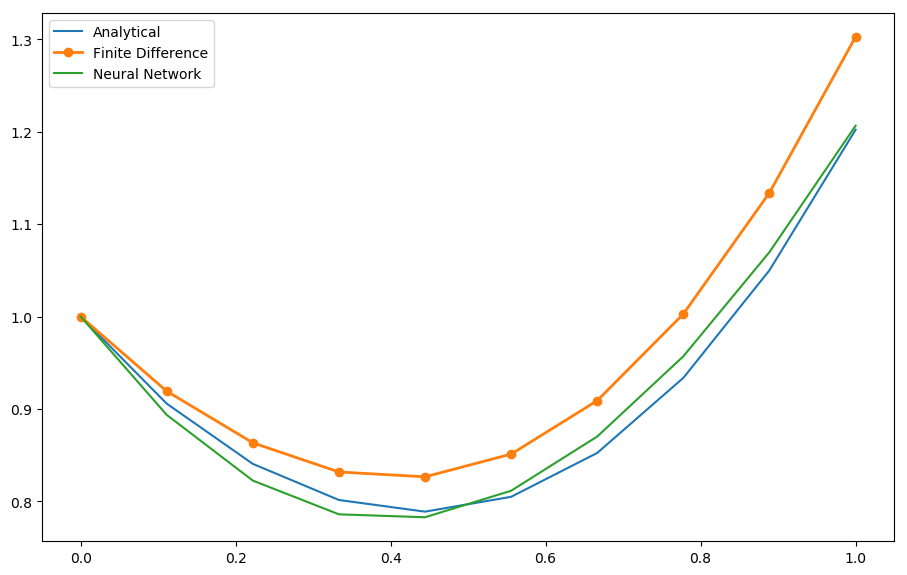

In [8]:
print(loss_function(W, x_space))
res = [1 + xi * neural_network(W, xi)[0][0] for xi in x_space] 

print(W)

plt.figure(figsize=(11, 7), dpi=100)
plt.plot(x_space, y_space, label='Analytical') 
plt.plot(x_space, psy_fd, marker='o', lw=2, label='Finite Difference')
plt.plot(x_space, res, label='Neural Network')
plt.legend()
plt.show()

## Preliminary Results
We are currently adapting the open source code from [5] [8] to solve the multiphase flow conservation laws. Following the remarkable accuracy results in the above results, our main goal is to show that machine learning methods could also be successfully used to approximate equations describing the multiphase flows. In addition, we plan to compare those solutions to our finite difference approximations.

## References
[4]	Fletcher, R. 1987. Practical Methods of Optimization. 2nd edition, John Wiley.

[5]	Lagaris, I. E., Likas, A., and Fotiadis, D. I. 1998 Artificial neural networks for solving ordinary and partial differential equations. Mathematics, Physics, Medicine, Computer Science. Published in IEEE Trans. Neural Networks.

[6]	LeVeque, R. J. 1992. Numerical Methods for Conservation Laws. Birkhauser Verlag.

[8]	Raissi, M., Perdikaris, P., and Karniadakis, G. E. 2017. Physics informed deep learning (part I): data-driven solutions of nonlinear partial differential equations. arXiv: 1711.10561.